# Fraudulent E-Commerce Transactions

**Description**

This dataset, "Fraudulent E-Commerce Transactions," contains transaction data from an e-commerce platform with a focus on fraud detection. It contains a variety of features commonly found in transactional data, with additional attributes specifically engineered to support the development and testing of fraud detection algorithms.

**Dataset Overview**

Number of Transactions in Version 1: 1,472,952

Number of Transactions in Version 2: 23,634

Features: 16

Fraudulent Transactions: Approximately 5%

**Problem Statement**

The objective of this project is to develop and implement a fraud detection model for an e-commerce platform. The goal is to create a machine learning model that can accurately classify transactions as fraudulent or legitimate based on various features, ensuring the model minimizes false negatives to detect as many fraudulent transactions as possible, while maintaining an acceptable balance with precision. This will help improve the platform’s ability to prevent financial losses, mitigate risks, and enhance customer trust by quickly identifying fraudulent activities.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipaddress
import xgboost as xgb
import lightgbm as lgb
import seaborn as sns
import random

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit, GroupShuffleSplit, train_test_split
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, roc_auc_score, confusion_matrix, make_scorer

from spectralcluster import SpectralClusterer
from sklearn.cluster import SpectralClustering
from sklearn.datasets import make_blobs

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from collections import defaultdict
from kneed import KneeLocator

import joblib
import os

import lime
import lime.lime_tabular

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


In [2]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore")
np.seterr(divide='ignore', invalid='ignore')
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", message=".*l1_ratio parameter is only used when penalty.*")

In [3]:
random.seed(58)
np.random.seed(58)

In [4]:
data = pd.read_csv("raw_data/Fraudulent_E-Commerce_Transaction_Data.csv")
data2 = pd.read_csv("raw_data/Fraudulent_E-Commerce_Transaction_Data_2.csv")
df = pd.concat([data, data2], ignore_index=True)

## EDA

In [9]:
df.isna().sum()

Transaction ID        0
Customer ID           0
Transaction Amount    0
Transaction Date      0
Payment Method        0
Product Category      0
Quantity              0
Customer Age          0
Customer Location     0
Device Used           0
IP Address            0
Shipping Address      0
Billing Address       0
Is Fraudulent         0
Account Age Days      0
Transaction Hour      0
dtype: int64

### Finding number of frauds and non-frauds in the dataset.

In our dataset, fraud cases are significantly outnumbered by non-fraud cases, leading to an imbalanced dataset. Training on the full dataset can cause the model to be biased toward predicting non-fraud cases, resulting in poor fraud detection. Additionally, using the full dataset significantly increases computation time, making model training inefficient.

To address this, we apply negative sampling, where we randomly select a subset of non-fraud cases instead of using all of them. This approach reduces training time, ensures the model learns meaningful fraud patterns, and maintains statistical relevance. Specifically, we sample 1.5× the number of fraud cases from the non-fraud class by taking an integer division of 3 times the number of fraud cases by 2. This strikes a balance between efficiency and effective learning while keeping the model exposed to a diverse set of non-fraud examples.


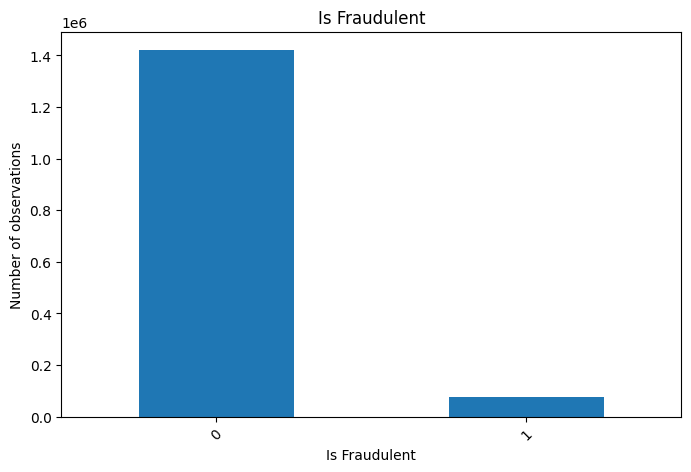

In [10]:
df['Is Fraudulent'].value_counts().plot(kind='bar', figsize=(8, 5))
plt.title('Is Fraudulent')
plt.xlabel('Is Fraudulent')
plt.ylabel('Number of observations')
plt.xticks(rotation=45)
plt.show()

#### Train test split and undersampling before doing EDA to prevent data leakage

In [5]:
fraud_df = df[df["Is Fraudulent"] == 1]
non_fraud_df = df[df["Is Fraudulent"] == 0]
sampled_non_fraud_df = non_fraud_df.sample(n=fraud_df.shape[0] * 3 // 2)
untouched_df = non_fraud_df.drop(sampled_non_fraud_df.index)
sampled_df = pd.concat([fraud_df, sampled_non_fraud_df], axis=0)
train_df, test_df = train_test_split(sampled_df, test_size=0.2, random_state=58)
train_df, test_df = train_df.reset_index(drop=True), test_df.reset_index(drop=True)

## EDA

### Transaction Amount vs. Quantity

This scatter plot visualizes the relationship between Transaction Amount and Quantity, with points colored by whether the transaction was fraudulent (Is Fraudulent = 1) or not fraudulent (Is Fraudulent = 0).

*   Transaction Amount varies widely, with several transactions reaching high values (over 10,000).
*   Fraudulent transactions (orange) appear across all quantity levels but are more densely populated at higher transaction amounts.
*   In contrast, non-fraudulent transactions (blue) tend to cluster at lower transaction amounts, especially below the 2,000 mark.

High transaction amounts are more likely to be associated with fraudulent transactions, especially when paired with lower quantities.

We decided to engineer the feature `single_item_transaction`, which is the ratio of Transaction Amount to Quantity, as it isolates the per-item price, which is an important indicator of transaction legitimacy. Fraudulent transactions, often characterized by high transaction amounts and low quantities, will typically have a higher per-item price, making them more easily detectable.

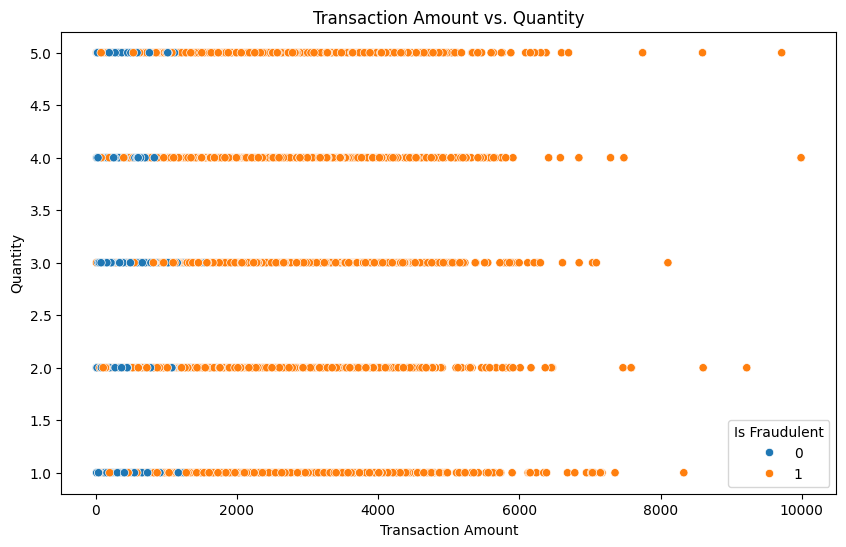

In [6]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=train_df, x='Transaction Amount', y='Quantity', hue='Is Fraudulent')
plt.title('Transaction Amount vs. Quantity')
plt.xlabel('Transaction Amount')
plt.ylabel('Quantity')
plt.show()

### Account Age Distribution for Fraudulent and Non-Fraudulent Transactions




*   Non-fraudulent transactions (Is Fraudulent = 0) generally
involve older accounts

Median account age is significantly higher compared to fraudulent transactions. The interquartile range (middle 50% of values) stretches from about ~90 to ~275 days.

*   Fraudulent transactions (Is Fraudulent = 1) are more common among newer accounts:

Median account age is around ~60 days. A large portion of these accounts are very new, with many under 100 days old.
*   Both groups show similar upper bounds (maximum account ages), but fraudulent transactions are more skewed toward younger accounts.


Account age is a strong signal: fraud is more prevalent in newer accounts, potentially due to limited trust or incomplete verification processes.

From our feature selection later on, account age days was also selected.



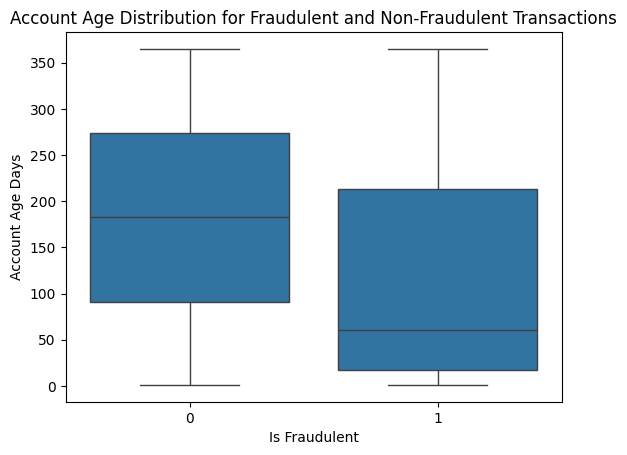

In [13]:
sns.boxplot(x='Is Fraudulent', y='Account Age Days', data=train_df)
plt.title('Account Age Distribution for Fraudulent and Non-Fraudulent Transactions')
plt.show()

## Initial Feature Engineering

### Converting datetime object and adding day, month features

The `Transaction Day` and `Transaction Month` and `Time of Day` features were engineered to capture daily and monthly patterns in transaction behavior. These features help identify potential seasonal or time-based trends in fraud, such as spikes on specific days or months. By incorporating these temporal signals, the model can improve fraud detection accuracy by recognizing when fraud is more likely to occur based on past behavior.

The feature `time_of_day` was engineered to capture the time at which a transaction occurs, categorizing each transaction into one of four time periods.

Fraudulent activities often exhibit different patterns depending on the time of day. By categorizing transactions into different times of day, we can identify if fraud is more likely to occur during specific periods. For instance, fraudulent transactions might be more likely to occur late at night when fewer people are monitoring systems, or in the early morning when systems may not be fully staffed.

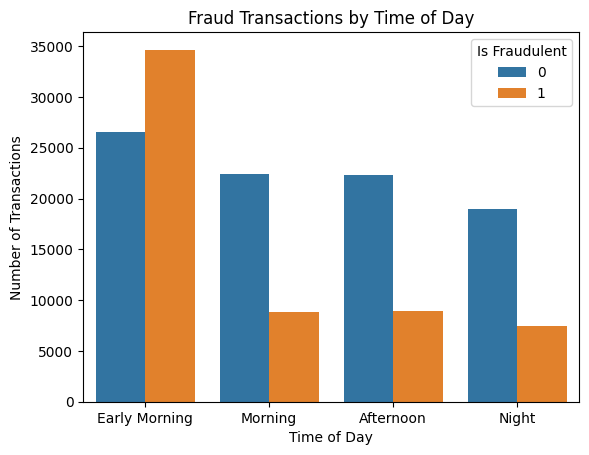

In [7]:
def process_date(df):
    df['Transaction Date'] = pd.to_datetime(df['Transaction Date'])
    df['Transaction Day'] = df['Transaction Date'].dt.day
    df['Transaction Month'] = df['Transaction Date'].dt.month

    def categorize_hour(hour):
        if 0 <= hour <= 6:
            return "Early Morning"
        elif 7 <= hour <= 12:
            return "Morning"
        elif 13 <= hour <= 18:
            return "Afternoon"
        else:
            return "Night"

    df['time_of_day'] = df['Transaction Hour'].apply(categorize_hour)

process_date(train_df)
process_date(test_df)

sns.countplot(data=train_df, x='time_of_day', hue='Is Fraudulent', order=['Early Morning', 'Morning', 'Afternoon', 'Night'])
plt.title('Fraud Transactions by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Number of Transactions')
plt.show()

### Creating a new binary feature that checks whether the Shipping Address and Billing Address are the same.



1.   Legitimate Transactions Often Have Matching Addresses

In genuine transactions, the shipping and billing addresses are usually the same (e.g., people often ship items to their home address, which is also their billing address). This means that transactions where Same add = 1 are more likely to be legitimate.
2.   Fraudulent Transactions Often Have Different Addresses

Fraudsters often use stolen credit card details and may ship items to a different address (to avoid detection by the real card owner). A mismatch (Same add = 0) can be a red flag for fraud. For example, a fraudster in Country A might use a stolen card from Country B but ship the product to their own location.



In [8]:
train_df["Same add"] = (train_df["Shipping Address"] != train_df["Billing Address"]).astype(int)
test_df["Same add"] = (test_df["Shipping Address"] != test_df["Billing Address"]).astype(int)

### Finding single item transactions

This calculates the average price per item in each transaction. It helps normalize transaction amounts based on how many items were purchased. For example:


*   A transaction with a high total amount but also a large quantity might not be suspicious.
*   Conversely, a high average item price for a low-quantity purchase could be a potential red flag for fraud.


By introducing this feature, we give the model more granularity to distinguish between normal and anomalous spending behavior on a per-item basis, rather than relying only on total amounts.

In [9]:
train_df["single_item_transaction"] = train_df["Transaction Amount"] / train_df["Quantity"]
test_df["single_item_transaction"] = test_df["Transaction Amount"] / test_df["Quantity"]

### Checks if ipaddress is private

The `is_private` feature was engineered to identify transactions originating from private IP addresses, which may indicate suspicious or fraudulent activity, such as the use of VPNs or proxies. This binary feature helps the model detect potential fraud by flagging transactions from hidden or anonymized sources, improving fraud detection accuracy.

In [10]:
train_df["is_private"] = train_df["IP Address"].apply(lambda x: ipaddress.ip_address(x).is_private).astype(int)
test_df["is_private"] = test_df["IP Address"].apply(lambda x: ipaddress.ip_address(x).is_private).astype(int)

### Categorise age into bins

By categorizing the continuous `Customer Age` variable into discrete bins, we can simplify the relationship between age and the target variable, making it easier for models to interpret.

Tree-based models like XGBoost can indeed work better with categorical features, as they can naturally handle and split data based on these categories, capturing non-linear relationships more effectively.

In [11]:
bins = [0, 10, 20, 30, 40, 50, 60, float('inf')]
labels = ["Below 10", "10-20", "20-30", "30-40", "40-50", "50-60", "60 Above"]

train_df['Age Category'] = pd.cut(train_df['Customer Age'], bins=bins, labels=labels, right=False)
test_df['Age Category'] = pd.cut(test_df['Customer Age'], bins=bins, labels=labels, right=False)

### Remove unnecessary columns

In [12]:
columns_to_remove = ["Transaction Hour", "Transaction ID", "Customer ID", "Transaction Date", "Customer Location", "Customer Age", "Shipping Address", "Billing Address", "IP Address", "Quantity", "Transaction Amount"]
train_df = train_df.drop(columns=columns_to_remove)
test_df = test_df.drop(columns=columns_to_remove)

### One hot encoding for categorical columns

In [13]:
categorical_cols = ['Transaction Day', 'Payment Method', 'Device Used', 'Age Category', "Transaction Month", "time_of_day", "Product Category"]
train_df = pd.get_dummies(train_df, columns=categorical_cols, dtype=int)
test_df = pd.get_dummies(test_df, columns=categorical_cols, dtype=int)

### Split into features and labels

In [14]:
X_train, y_train = train_df.drop(columns="Is Fraudulent"), train_df["Is Fraudulent"]
X_test, y_test = test_df.drop(columns="Is Fraudulent"), test_df["Is Fraudulent"]

### Add cluster labels as features

We wanted to incorporate cluster labels from unsupervised learning models such as KMeans, Gaussian Mixture Models (GMM), and Isolation Forest (ISO) into this supervised learning tasks (classification)  as it can enhance model performance by capturing hidden patterns or groupings in the data that aren’t directly represented by original features.

* KMeans: Captures linear, centroid-based clusters. Good for spherical clusters.
* GMM: Soft clustering based on probabilistic distributions. Captures more complex, elliptical clusters.
* Isolation Forest: Identifies anomalies or rare patterns rather than clusters per se, making it ideal for fraud or rare event detection.


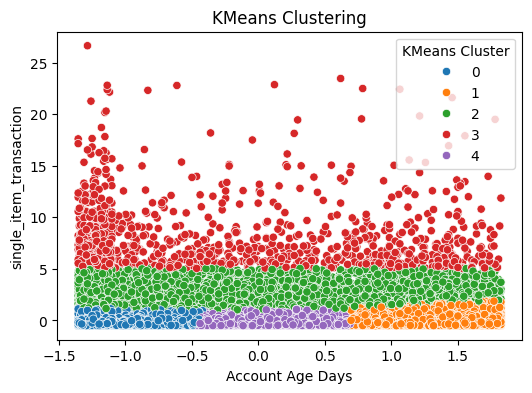

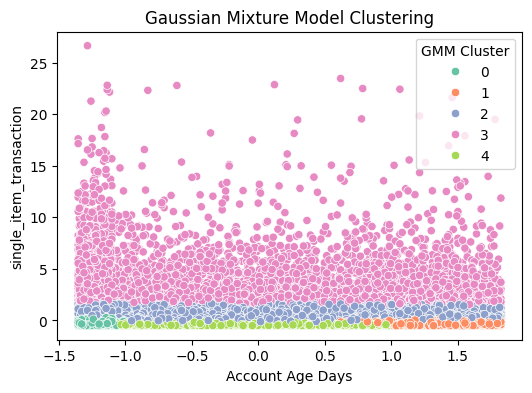

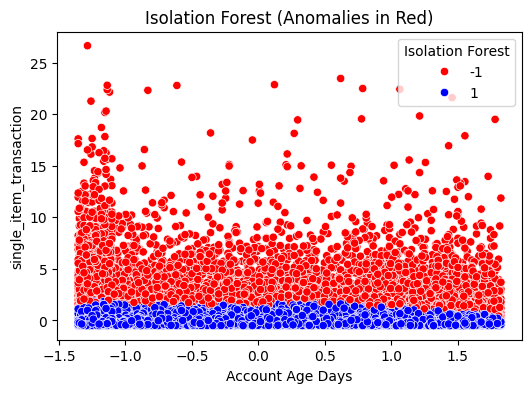

In [15]:
# Subset the data
df_cluster = train_df[['Account Age Days', 'single_item_transaction']].copy()

# # Apply min-max scaling to each column
# min_max(df_cluster, col_name='Account Age Days')
# min_max(df_cluster, col_name='single_item_transaction')
scaler = StandardScaler()
df_cluster[['Account Age Days', 'single_item_transaction']] = scaler.fit_transform(
    df_cluster[['Account Age Days', 'single_item_transaction']]
)
# Prepare data for modeling
X = df_cluster[['Account Age Days', 'single_item_transaction']].values

# ----------------- KMeans -----------------
kmeans = KMeans(n_clusters=5, random_state=42)
df_cluster['KMeans Cluster'] = kmeans.fit_predict(X)

# Plot KMeans results
plt.figure(figsize=(6, 4))
sns.scatterplot(data=df_cluster, x='Account Age Days', y='single_item_transaction', hue='KMeans Cluster', palette='tab10')
plt.title('KMeans Clustering')
plt.show()

# ----------------- Gaussian Mixture Model -----------------
gmm = GaussianMixture(n_components=5, random_state=42)
df_cluster['GMM Cluster'] = gmm.fit_predict(X)

# Plot GMM results
plt.figure(figsize=(6, 4))
sns.scatterplot(data=df_cluster, x='Account Age Days', y='single_item_transaction', hue='GMM Cluster', palette='Set2')
plt.title('Gaussian Mixture Model Clustering')
plt.show()

# ----------------- Isolation Forest -----------------
iso_forest = IsolationForest(contamination=0.05, random_state=42)
df_cluster['Isolation Forest'] = iso_forest.fit_predict(X)  # -1 = anomaly, 1 = normal

# Plot Isolation Forest results
plt.figure(figsize=(6, 4))
sns.scatterplot(data=df_cluster, x='Account Age Days', y='single_item_transaction',
                hue='Isolation Forest', palette={1: 'blue', -1: 'red'})
plt.title('Isolation Forest (Anomalies in Red)')
plt.show()

# Model Training and Evaluation

## Traditional Models Training with StratifiedKfoldCV

In this approach, we nest feature selection, oversampling, and clustering inside the KFold cross-validation process to ensure a robust evaluation of the model performance. By integrating these steps into each fold, we avoid data leakage, ensuring that each fold is treated independently, with no prior knowledge of the validation data influencing the model.

* Feature selection is applied separately within each K-1 training fold to reduce dimensionality, helping improve model efficiency.
* Oversampling is also performed within each fold (and oversample for that K-1 folds) to balance the class distribution and prevent the model from being biased toward the majority class. We also use oversampling instead of SMOTE because smote is not good for categorical features
* Clustering models, like KMeans, Isolation Forest, and Gaussian Mixture Models, are used to extract additional features from the data, potentially revealing hidden patterns and improving the model’s prediction ability.

By training the models on oversampled and transformed data, we ensure that the evaluation metrics are more representative of real-world performance, while the random search for hyperparameters further fine-tunes the model’s generalization capability. This comprehensive strategy ensures that all steps contribute to optimizing the model without introducing bias or data leakage.



We prioritize the F2-score because it places more emphasis on recall than precision, making it particularly valuable in fraud situations where minimizing false negatives is more important than controlling false positives.

In [16]:
def further_feature_engineer(X_train, X_test, k=None, min_k=2, max_k=10, cluster_type="all"):
    X_train_new, X_test_new = X_train.copy(), X_test.copy()
    scaler = StandardScaler()
    X_train_new[['Account Age Days', 'single_item_transaction']] = scaler.fit_transform(
        X_train_new[['Account Age Days', 'single_item_transaction']]
    )
    X_test_new[['Account Age Days', 'single_item_transaction']] = scaler.transform(
        X_test_new[['Account Age Days', 'single_item_transaction']]
    )

    if cluster_type is None: # if there is no clustering
        return X_train_new, X_test_new, scaler

    # Determine best k using elbow method if not provided
    if k is None and cluster_type in ["kmeans", "gmm", "all"]:
        inertias = []
        K_range = range(min_k, max_k + 1)
        for i in K_range:
            km = KMeans(n_clusters=i, random_state=58)
            km.fit(X_train)
            inertias.append(km.inertia_)

        plt.figure(figsize=(8, 5))
        plt.plot(K_range, inertias, 'bo-')
        plt.xlabel('Number of clusters k')
        plt.ylabel('Inertia')
        plt.title('Elbow Method For Optimal k')
        plt.grid(True)

        try:
            kl = KneeLocator(K_range, inertias, curve="convex", direction="decreasing")
            k = kl.elbow
            if k is not None:
                plt.axvline(x=k, color='r', linestyle='--', label=f'Elbow at k={k}')
                print(f"[Elbow Method] Optimal k found: {k}")
            else:
                print("[Elbow Method] No elbow found. Using default k=5.")
                k = 5
        except Exception as e:
            print(f"[Elbow Method] Failed to compute elbow: {e}. Using default k=5.")
            k = 5

        plt.legend()
        plt.tight_layout()
        plt.show()
    elif cluster_type not in ["kmeans", "gmm", "all"]:
        k = None  # Not needed for Isolation Forest
    else:
        print(f"[Manual k] Using k={k}")

    new_columns = []

    # KMeans clustering
    if cluster_type in ["kmeans", "all"]:
        kmeans = KMeans(n_clusters=k, random_state=58)
        kmeans.fit(X_train)
        X_train_new['kmeans_cluster'] = kmeans.predict(X_train)
        X_test_new['kmeans_cluster'] = kmeans.predict(X_test)
        new_columns.append("kmeans_cluster")

    # Gaussian Mixture Model clustering
    if cluster_type in ["gmm", "all"]:
        gmm = GaussianMixture(n_components=k, random_state=58)
        gmm.fit(X_train)
        X_train_new['gmm_cluster'] = gmm.predict(X_train)
        X_test_new['gmm_cluster'] = gmm.predict(X_test)
        new_columns.append("gmm_cluster")

    # Isolation Forest anomaly detection
    if cluster_type in ["isolation_forest", "all"]:
        iso_forest = IsolationForest(random_state=58)
        iso_forest.fit(X_train)
        X_train_new['iso_cluster'] = iso_forest.predict(X_train)
        X_test_new['iso_cluster'] = iso_forest.predict(X_test)
        new_columns.append("iso_cluster")

    # One-hot encoding for cluster labels
    X_train_new = pd.get_dummies(X_train_new, columns=new_columns, dtype=int)
    X_test_new = pd.get_dummies(X_test_new, columns=new_columns, dtype=int)

    # Align columns
    missing_cols = X_train_new.columns.difference(X_test_new.columns)
    for col in missing_cols:
        X_test_new[col] = 0
    X_test_new = X_test_new[X_train_new.columns]

    return X_train_new, X_test_new, scaler

### Stratified 5-Fold Cross Validation

In [ ]:
clustering_types = [None, 'kmeans', 'gmm', 'iso']
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=58)

# Create a custom scorer for F2
f2_scorer = make_scorer(fbeta_score, beta=2)

models = {
    'Random Forest': RandomForestClassifier(random_state=58, n_jobs=-1),
    'Logistic Regression': LogisticRegression(random_state=58),
    'XGBoost': xgb.XGBClassifier(eval_metric='logloss', random_state=58)
}

param_grids = {
    'Random Forest': {
        'model__n_estimators': [50, 100, 200, 300, 500],
        'model__max_depth': [3, 5, 7, 9, 11, 15],
        'model__min_samples_split': [2, 5, 10, 20],
        'model__min_samples_leaf': [1, 2, 4, 6]
    },
    'Logistic Regression': {
        'model__C': [0.001, 0.01, 0.1, 1, 2, 2.5, 3, 4],
        'model__penalty': ['elasticnet'],
        'model__solver': ['saga'],
        'model__l1_ratio': [None, 0.1, 0.5, 0.7, 1.0],
        'model__max_iter': [100, 200, 500, 1000],
    },
    'XGBoost': {
        'model__n_estimators': [50, 100, 200, 300, 500],
        'model__learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],
        'model__max_depth': [3, 5, 7, 10, 15],
        'model__subsample': [0.6, 0.7, 0.8, 1.0],
        'model__colsample_bytree': [0.6, 0.7, 0.8, 1.0],
        'model__gamma': [0, 0.1, 0.3, 0.5, 1.0],
        'model__reg_lambda': [0.5, 1, 1.5, 2, 5],
        'model__reg_alpha': [0, 0.1, 0.5, 1.0]
    }
}


====================== Clustering Type: NONE ======================

--- Model: Random Forest ---
Fold 1
F2 score: 0.7367 | AUC: 0.7903
Fold 2
F2 score: 0.7393 | AUC: 0.7930
Fold 3
F2 score: 0.7455 | AUC: 0.7980
Fold 4
F2 score: 0.7536 | AUC: 0.7983
Fold 5
F2 score: 0.7432 | AUC: 0.7940

Model: Random Forest | Avg F2: 0.7436 ± 0.0058 | Avg AUC: 0.7947 ± 0.0031

--- Model: Logistic Regression ---
Fold 1


/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which 

F2 score: 0.6418 | AUC: 0.7646
Fold 2


/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which 

F2 score: 0.6385 | AUC: 0.7617
Fold 3


/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which 

F2 score: 0.6431 | AUC: 0.7703
Fold 4


/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which 

F2 score: 0.6447 | AUC: 0.7681
Fold 5


/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which 

F2 score: 0.6383 | AUC: 0.7606

Model: Logistic Regression | Avg F2: 0.6413 ± 0.0025 | Avg AUC: 0.7651 ± 0.0037

--- Model: XGBoost ---
Fold 1
F2 score: 0.7184 | AUC: 0.7960
Fold 2
F2 score: 0.7382 | AUC: 0.7943
Fold 3
F2 score: 0.7278 | AUC: 0.8044
Fold 4
F2 score: 0.7095 | AUC: 0.8049
Fold 5
F2 score: 0.7254 | AUC: 0.7960

Model: XGBoost | Avg F2: 0.7239 ± 0.0096 | Avg AUC: 0.7991 ± 0.0046

====================== Clustering Type: KMEANS ======================

--- Model: Random Forest ---
Fold 1
[Elbow Method] Optimal k found: 5


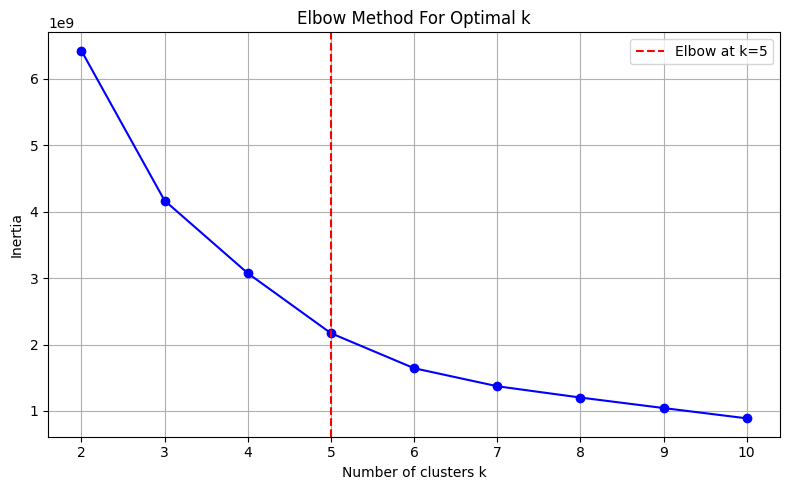

F2 score: 0.6809 | AUC: 0.7932
Fold 2
[Elbow Method] Optimal k found: 5


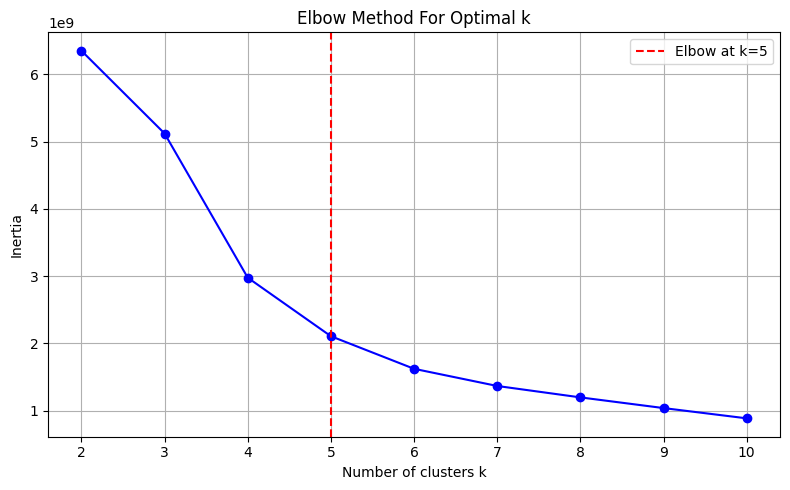

F2 score: 0.6795 | AUC: 0.7951
Fold 3
[Elbow Method] Optimal k found: 5


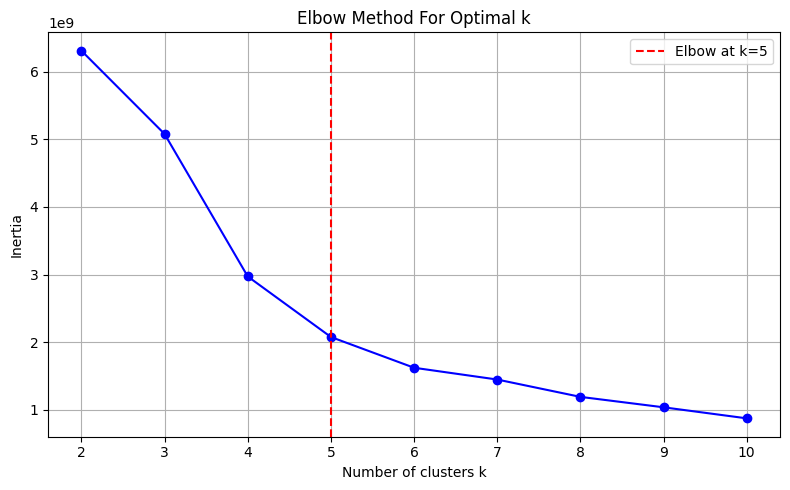

F2 score: 0.6869 | AUC: 0.7972
Fold 4
[Elbow Method] Optimal k found: 5


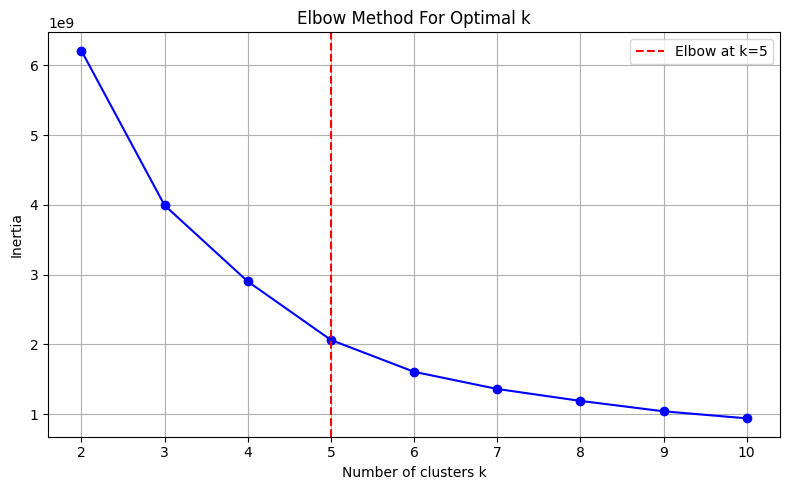

F2 score: 0.6912 | AUC: 0.7990
Fold 5
[Elbow Method] Optimal k found: 5


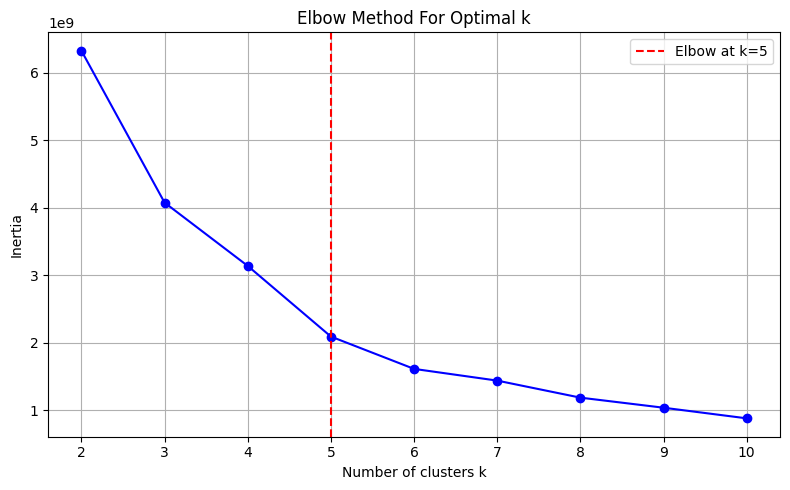

F2 score: 0.6859 | AUC: 0.7932

Model: Random Forest | Avg F2: 0.6849 ± 0.0042 | Avg AUC: 0.7956 ± 0.0023

--- Model: Logistic Regression ---
Fold 1
[Elbow Method] Optimal k found: 5


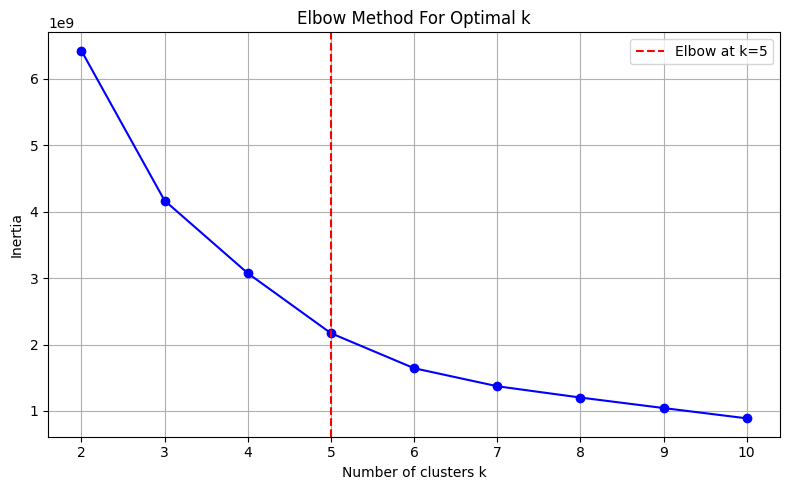

/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which 

F2 score: 0.6475 | AUC: 0.7658
Fold 2
[Elbow Method] Optimal k found: 5


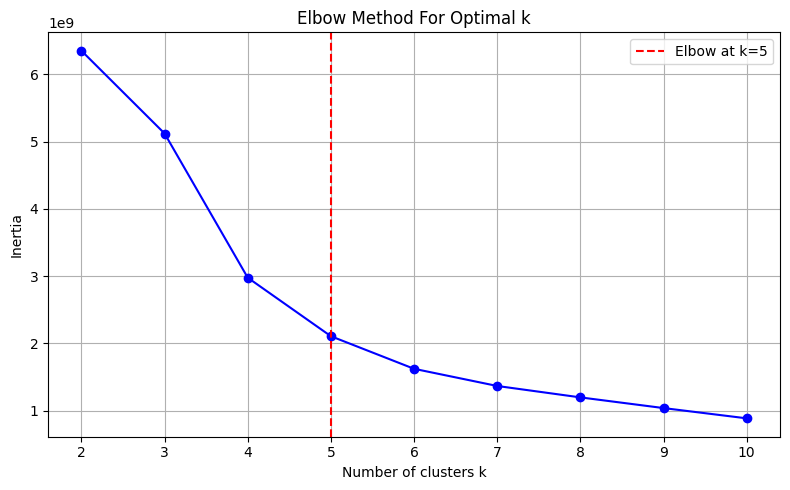

/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which 

F2 score: 0.6446 | AUC: 0.7620
Fold 3
[Elbow Method] Optimal k found: 5


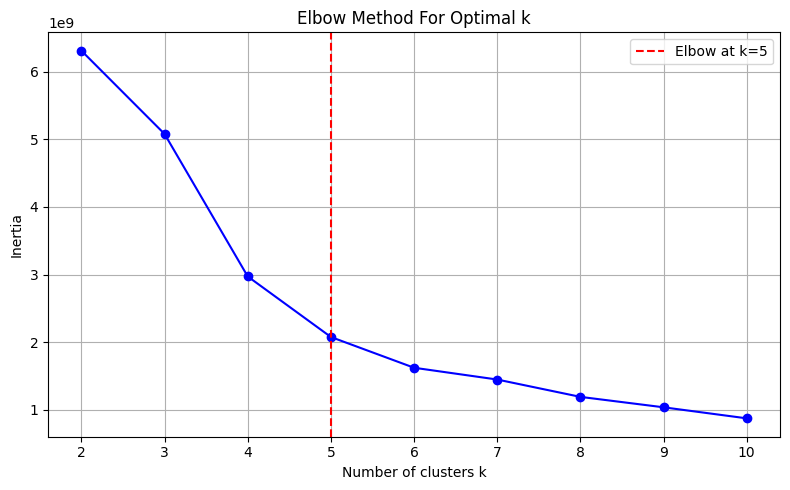

/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which 

F2 score: 0.6477 | AUC: 0.7712
Fold 4
[Elbow Method] Optimal k found: 5


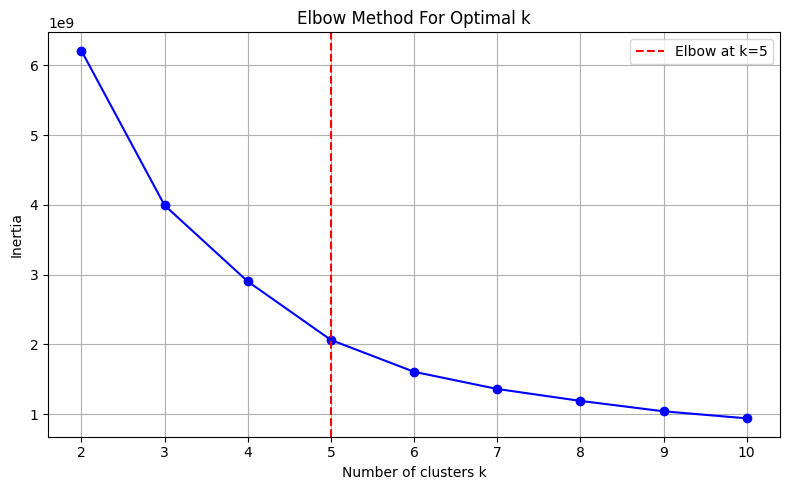

/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which 

F2 score: 0.6501 | AUC: 0.7697
Fold 5
[Elbow Method] Optimal k found: 5


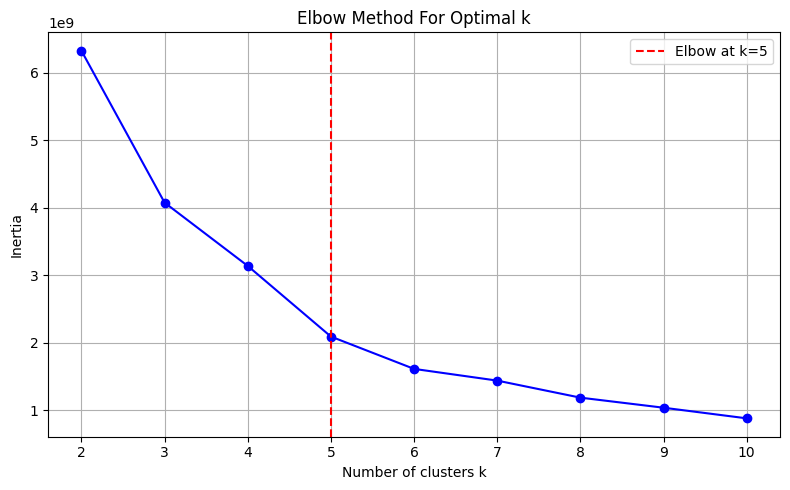

/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which 

F2 score: 0.6436 | AUC: 0.7610

Model: Logistic Regression | Avg F2: 0.6467 ± 0.0023 | Avg AUC: 0.7659 ± 0.0041

--- Model: XGBoost ---
Fold 1
[Elbow Method] Optimal k found: 5


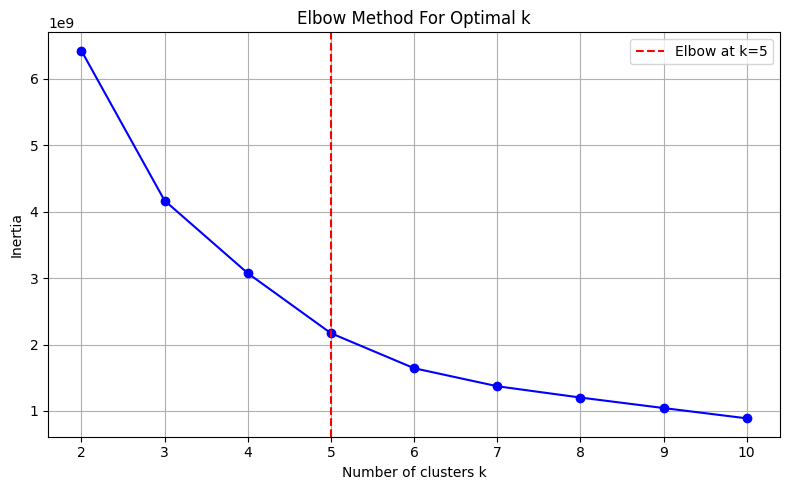

F2 score: 0.6850 | AUC: 0.7952
Fold 2
[Elbow Method] Optimal k found: 5


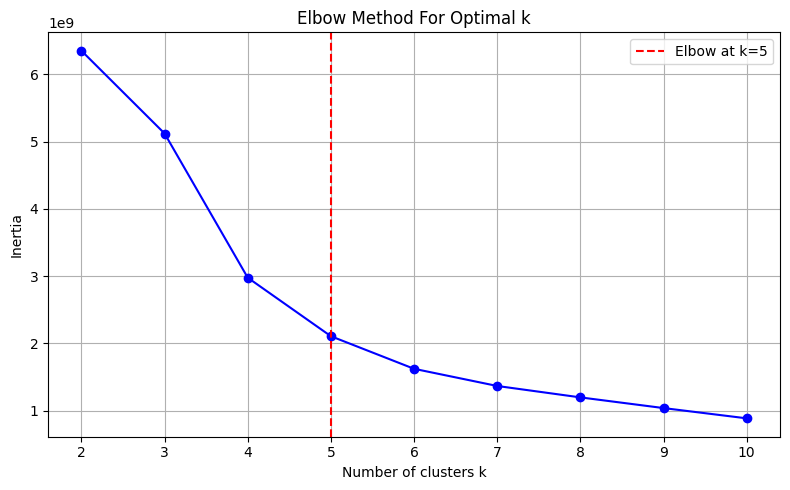

F2 score: 0.6847 | AUC: 0.7928
Fold 3
[Elbow Method] Optimal k found: 5


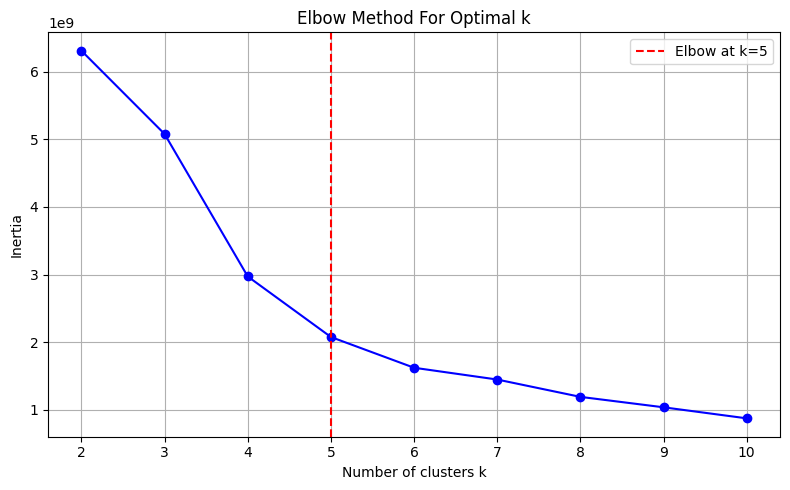

F2 score: 0.6943 | AUC: 0.7991
Fold 4
[Elbow Method] Optimal k found: 5


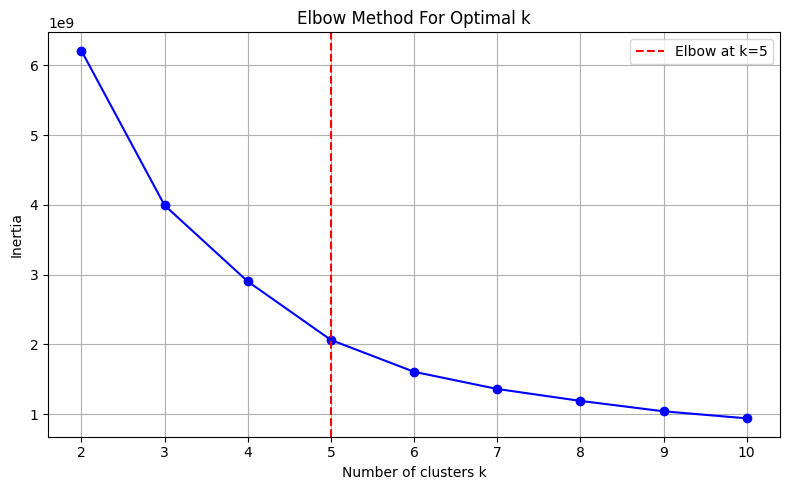

F2 score: 0.6752 | AUC: 0.7959
Fold 5
[Elbow Method] Optimal k found: 5


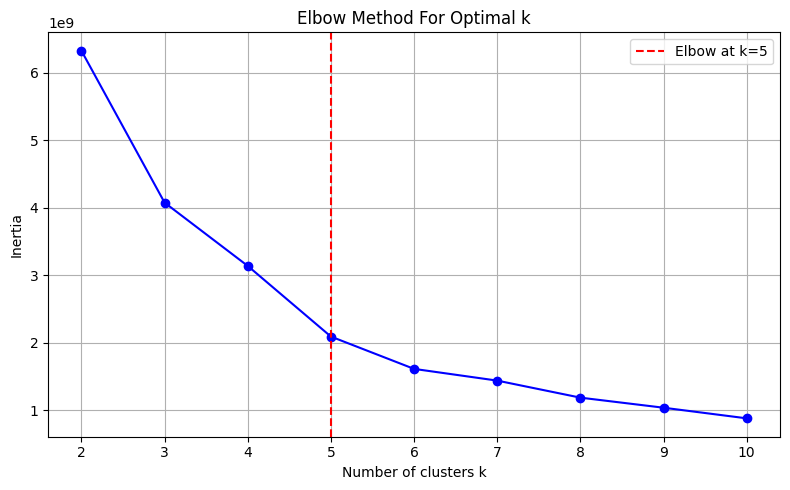

F2 score: 0.6890 | AUC: 0.7864

Model: XGBoost | Avg F2: 0.6857 ± 0.0063 | Avg AUC: 0.7939 ± 0.0043

====================== Clustering Type: GMM ======================

--- Model: Random Forest ---
Fold 1
[Elbow Method] Optimal k found: 5


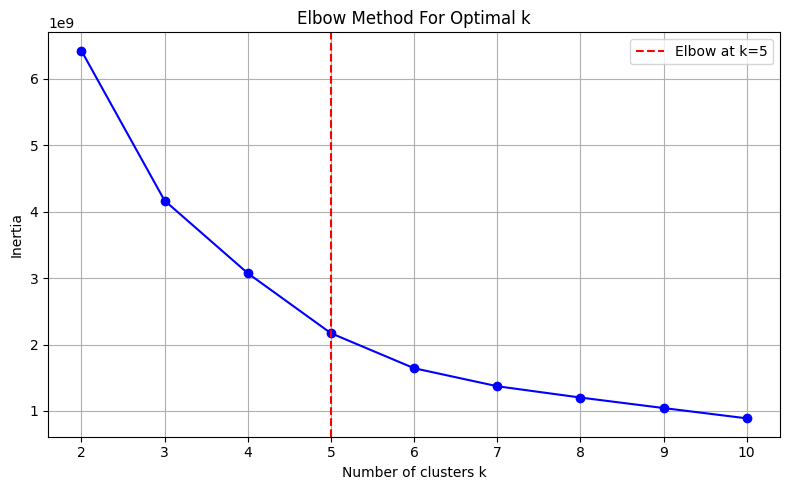

F2 score: 0.7395 | AUC: 0.7903
Fold 2
[Elbow Method] Optimal k found: 5


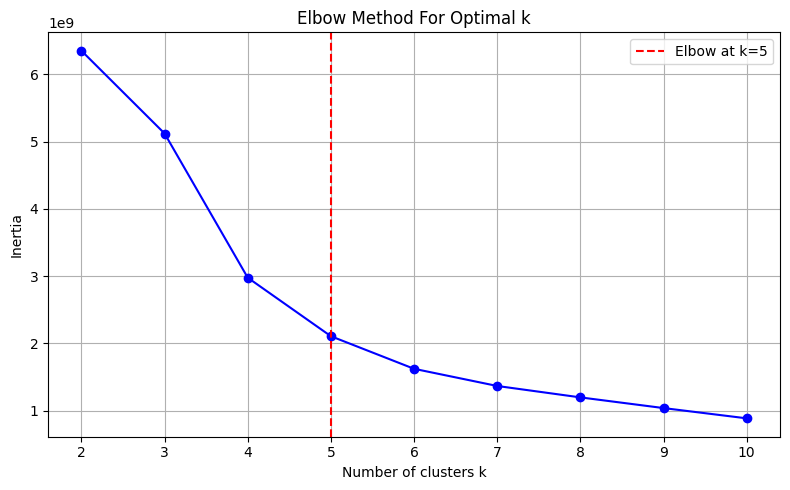

F2 score: 0.7389 | AUC: 0.7910
Fold 3
[Elbow Method] Optimal k found: 5


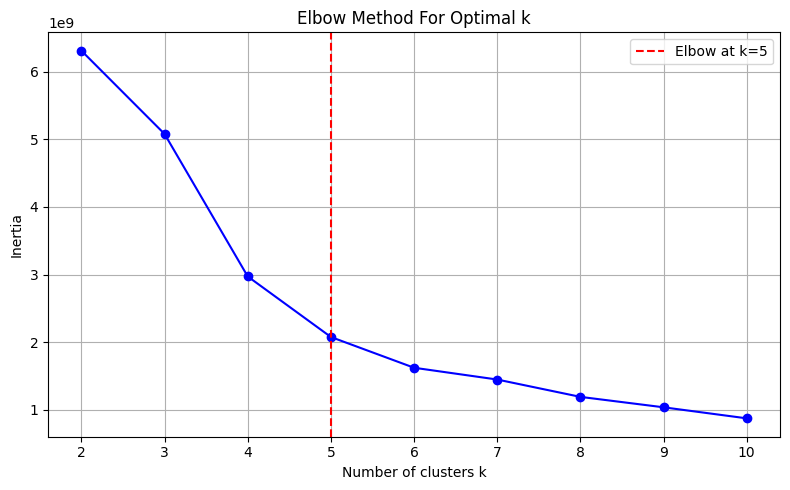

F2 score: 0.7450 | AUC: 0.7949
Fold 4
[Elbow Method] Optimal k found: 5


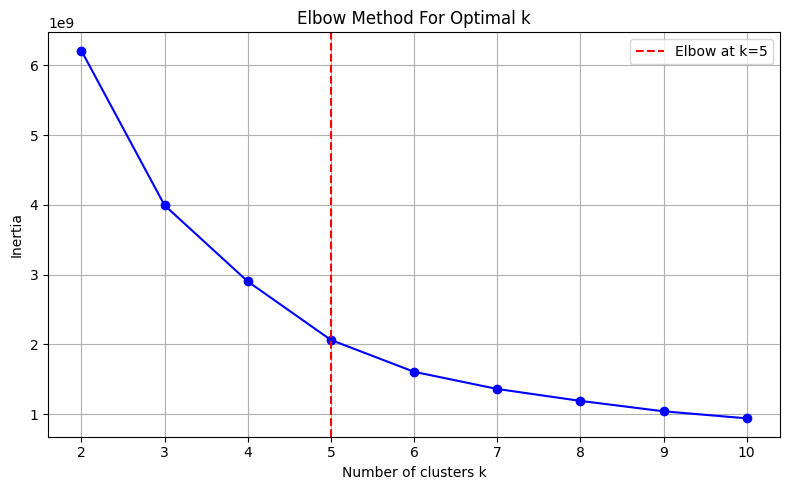

F2 score: 0.7545 | AUC: 0.7997
Fold 5
[Elbow Method] Optimal k found: 5


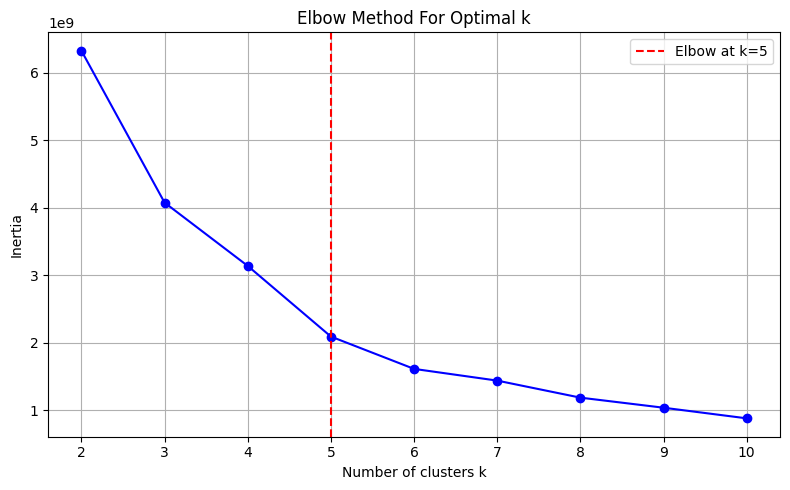

F2 score: 0.7436 | AUC: 0.7917

Model: Random Forest | Avg F2: 0.7443 ± 0.0056 | Avg AUC: 0.7935 ± 0.0035

--- Model: Logistic Regression ---
Fold 1
[Elbow Method] Optimal k found: 5


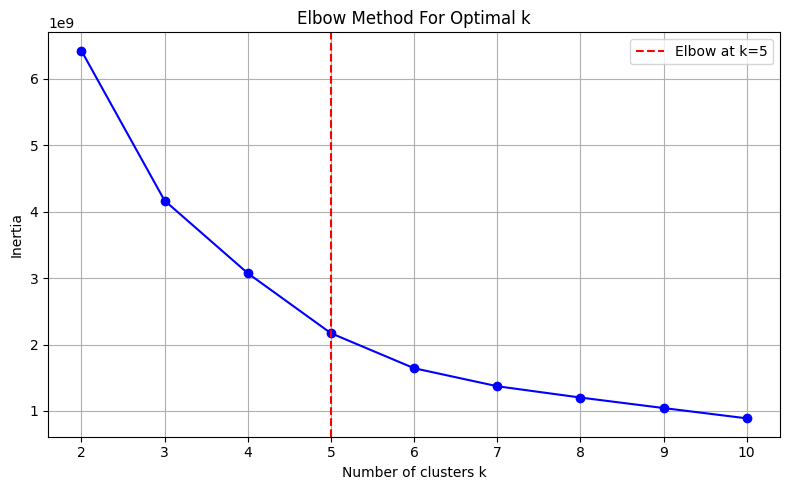

/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which 

F2 score: 0.6425 | AUC: 0.7646
Fold 2
[Elbow Method] Optimal k found: 5


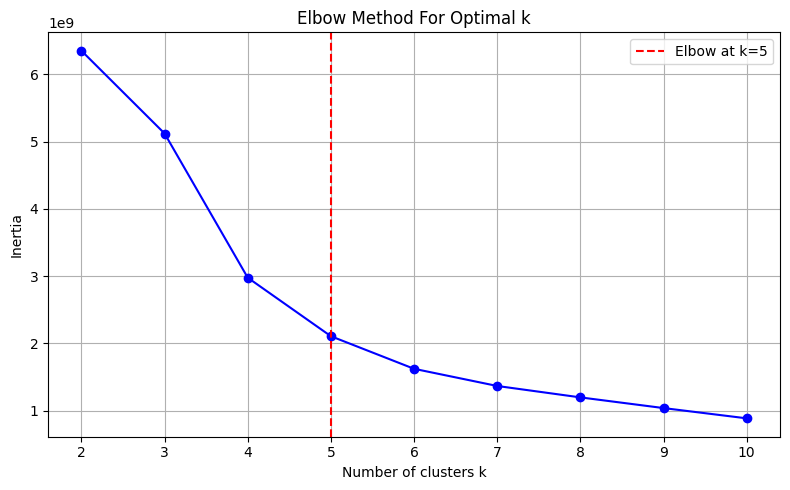

/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which 

F2 score: 0.6382 | AUC: 0.7618
Fold 3
[Elbow Method] Optimal k found: 5


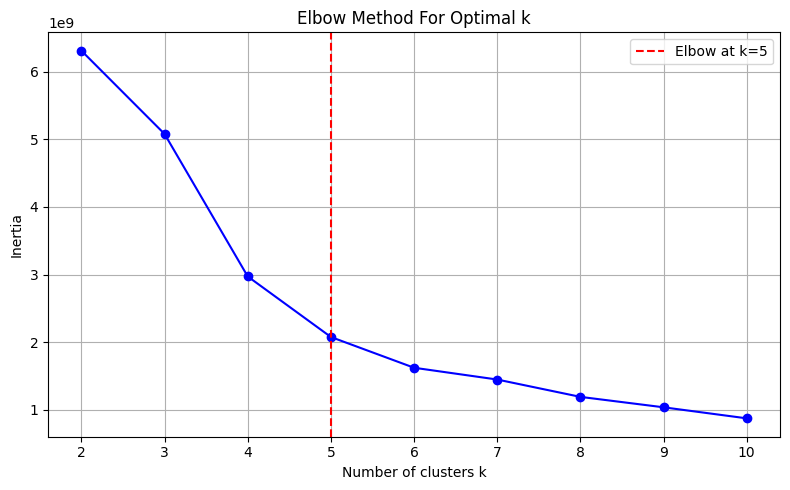

/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which 

F2 score: 0.6431 | AUC: 0.7703
Fold 4
[Elbow Method] Optimal k found: 5


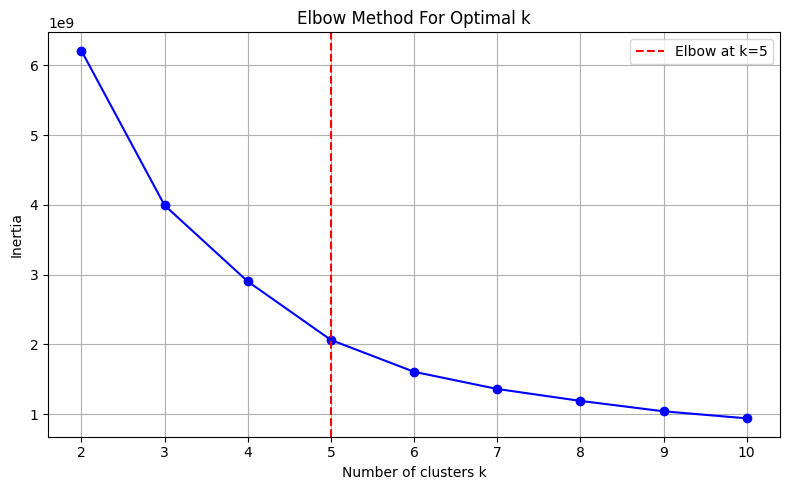

/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which 

F2 score: 0.6484 | AUC: 0.7677
Fold 5
[Elbow Method] Optimal k found: 5


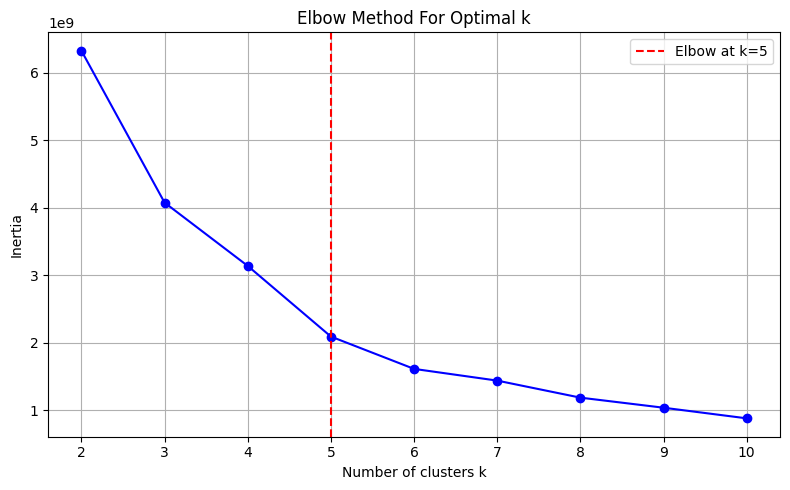

/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which 

F2 score: 0.6379 | AUC: 0.7606

Model: Logistic Regression | Avg F2: 0.6420 ± 0.0038 | Avg AUC: 0.7650 ± 0.0036

--- Model: XGBoost ---
Fold 1
[Elbow Method] Optimal k found: 5


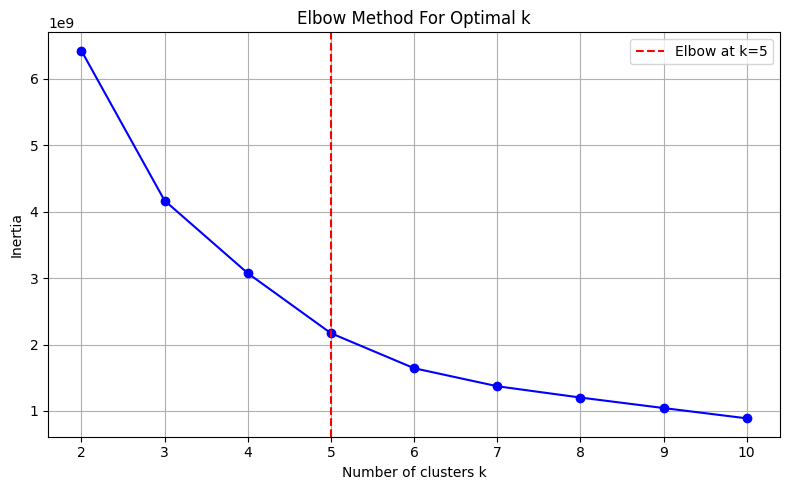

F2 score: 0.7422 | AUC: 0.7952
Fold 2
[Elbow Method] Optimal k found: 5


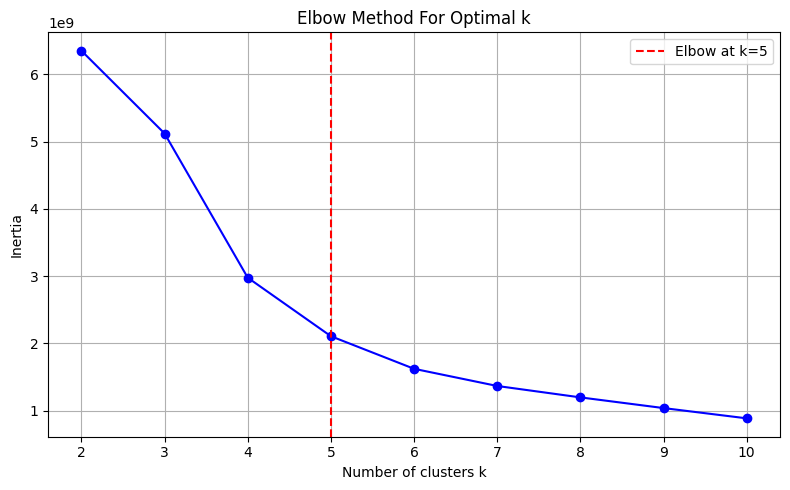

F2 score: 0.7401 | AUC: 0.7967
Fold 3
[Elbow Method] Optimal k found: 5


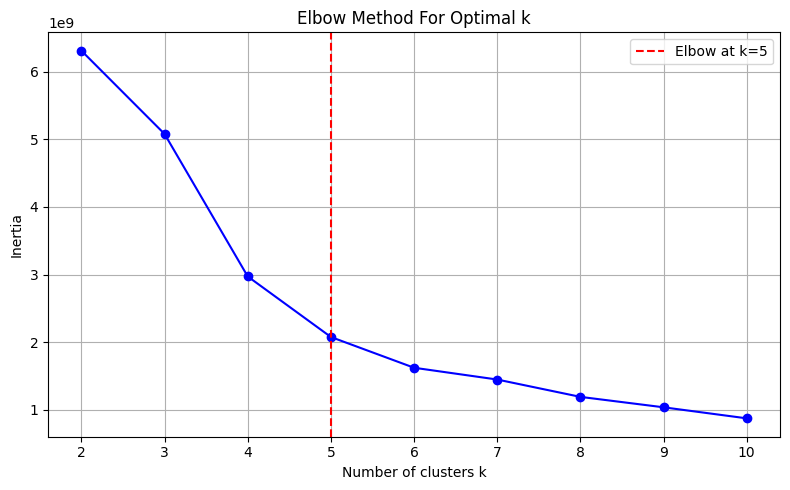

F2 score: 0.7508 | AUC: 0.7863
Fold 4
[Elbow Method] Optimal k found: 5


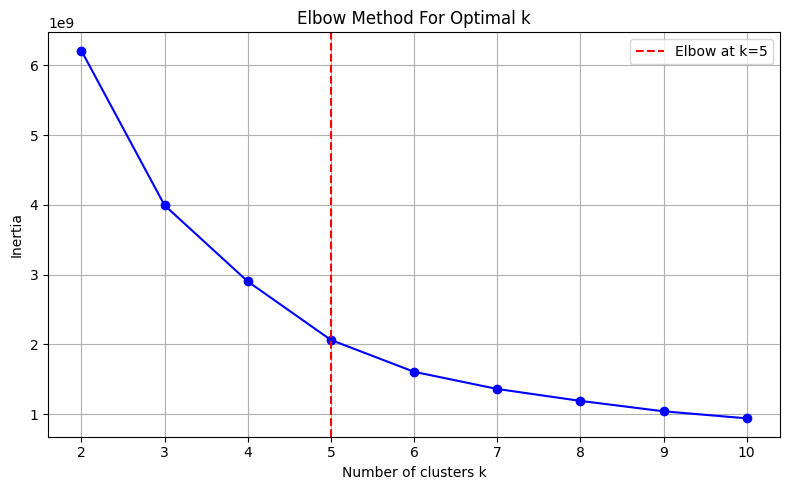

F2 score: 0.7558 | AUC: 0.8019
Fold 5
[Elbow Method] Optimal k found: 5


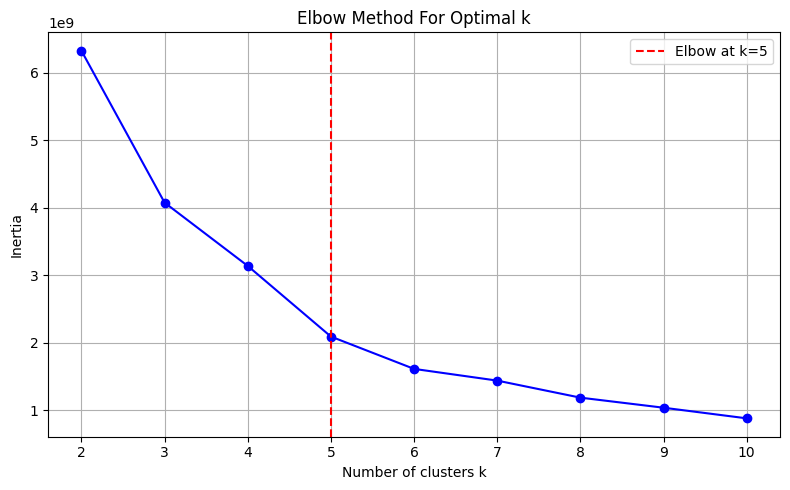

F2 score: 0.7423 | AUC: 0.7935

Model: XGBoost | Avg F2: 0.7462 ± 0.0060 | Avg AUC: 0.7947 ± 0.0050

====================== Clustering Type: ISO ======================

--- Model: Random Forest ---
Fold 1
F2 score: 0.7374 | AUC: 0.7907
Fold 2
F2 score: 0.7372 | AUC: 0.7939
Fold 3
F2 score: 0.7455 | AUC: 0.7980
Fold 4
F2 score: 0.7474 | AUC: 0.8005
Fold 5
F2 score: 0.7442 | AUC: 0.7933

Model: Random Forest | Avg F2: 0.7423 ± 0.0043 | Avg AUC: 0.7953 ± 0.0035

--- Model: Logistic Regression ---
Fold 1


/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which 

F2 score: 0.6421 | AUC: 0.7646
Fold 2


/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which 

F2 score: 0.6385 | AUC: 0.7617
Fold 3


/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which 

F2 score: 0.6432 | AUC: 0.7703
Fold 4


/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which 

F2 score: 0.6484 | AUC: 0.7677
Fold 5


/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which 

F2 score: 0.6375 | AUC: 0.7607

Model: Logistic Regression | Avg F2: 0.6419 ± 0.0039 | Avg AUC: 0.7650 ± 0.0036

--- Model: XGBoost ---
Fold 1
F2 score: 0.7390 | AUC: 0.7942
Fold 2
F2 score: 0.7331 | AUC: 0.7988
Fold 3
F2 score: 0.7568 | AUC: 0.7997
Fold 4
F2 score: 0.7238 | AUC: 0.8044
Fold 5
F2 score: 0.7175 | AUC: 0.7914

Model: XGBoost | Avg F2: 0.7340 ± 0.0136 | Avg AUC: 0.7977 ± 0.0045


In [ ]:
# To store results across all clustering types
all_results = {}

for cluster_type in clustering_types:
    print(f"\n====================== Clustering Type: {str(cluster_type).upper()} ======================")
    best_config_per_model = {}
    metrics_summary = {model_name: defaultdict(list) for model_name in models}

    for model_name, model in models.items():
        print(f"\n--- Model: {model_name} ---")
        f2_scores = []
        auc_scores = []

        for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train)):
            print(f"Fold {fold + 1}")

            X_t, X_val = X_train.iloc[train_idx].copy(), X_train.iloc[val_idx].copy()
            y_t, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

            # Use the chosen clustering type only
            X_t_fe, X_val_fe, _ = further_feature_engineer(X_t, X_val, cluster_type=cluster_type)

            pipeline = ImbPipeline([
                ('oversampler', RandomOverSampler(random_state=58)),
                ('model', model)
            ])

            search = RandomizedSearchCV(
                pipeline,
                param_distributions=param_grids[model_name],
                n_iter=30,
                cv=3,
                scoring=f2_scorer,
                n_jobs=-1,
                verbose=0
            )

            search.fit(X_t_fe, y_t)
            best_model = search.best_estimator_
            y_pred = best_model.predict(X_val_fe)

            y_proba = best_model.predict_proba(X_val_fe)[:, 1]  # Only use [:, 1] for binary classification

            acc = accuracy_score(y_val, y_pred)
            prec = precision_score(y_val, y_pred)
            rec = recall_score(y_val, y_pred)
            f1 = f1_score(y_val, y_pred)
            f2 = fbeta_score(y_val, y_pred, beta=2)
            auc = roc_auc_score(y_val, y_proba)

            metrics_summary[model_name]['accuracy'].append(acc)
            metrics_summary[model_name]['precision'].append(prec)
            metrics_summary[model_name]['recall'].append(rec)
            metrics_summary[model_name]['f1'].append(f1)
            metrics_summary[model_name]['f2'].append(f2)
            metrics_summary[model_name]['auc'].append(auc)

            f2_scores.append(f2)
            auc_scores.append(auc)

            print(f"F2 score: {f2:.4f} | AUC: {auc:.4f}")

        avg_f2 = np.mean(f2_scores)
        std_f2 = np.std(f2_scores)
        avg_auc = np.mean(auc_scores)
        std_auc = np.std(auc_scores)

        best_config_per_model[model_name] = {
            "score": avg_f2,
            "std_f2": std_f2,
            "avg_auc": avg_auc,
            "std_auc": std_auc,
            "best_params": search.best_params_
        }

        print(f"\nModel: {model_name} | Avg F2: {avg_f2:.4f} ± {std_f2:.4f} | Avg AUC: {avg_auc:.4f} ± {std_auc:.4f}")

    # Save results for this clustering type
    all_results[cluster_type] = {
        "metrics": metrics_summary,
        "best_params": best_config_per_model
    }

### Validation Results

In [ ]:
print("\n====================== FINAL SUMMARY REPORT FOR CV======================")

for cluster_type in clustering_types:
    print(f"\nClustering Type: {str(cluster_type).upper()}")

    for model_name in models:
        model_metrics = all_results[cluster_type]["metrics"][model_name]
        best_params = all_results[cluster_type]["best_params"][model_name]["best_params"]

        acc = np.mean(model_metrics['accuracy'])
        prec = np.mean(model_metrics['precision'])
        rec = np.mean(model_metrics['recall'])
        f1 = np.mean(model_metrics['f1'])
        f2 = np.mean(model_metrics['f2'])
        auc = np.mean(model_metrics['auc'])

        f2_std = np.std(model_metrics['f2'])
        auc_std = np.std(model_metrics['auc'])

        print(f"\n--- Model: {model_name} ---")
        print(f"Average Accuracy:  {acc:.4f}")
        print(f"Average Precision: {prec:.4f}")
        print(f"Average Recall:    {rec:.4f}")
        print(f"Average F1-score:  {f1:.4f}")
        print(f"F2-score:     {f2:.4f} ± {f2_std:.4f}")
        print(f"ROC-AUC:      {auc:.4f} ± {auc_std:.4f}")
        print(f"Best Params:       {best_params}")


====================== FINAL SUMMARY REPORT FOR CV======================

Clustering Type: NONE

--- Model: Random Forest ---
Average Accuracy:  0.6999
Average Precision: 0.5927
Average Recall:    0.7942
Average F1-score:  0.6788
F2-score:     0.7436 ± 0.0058
ROC-AUC:      0.7947 ± 0.0031
Best Params:       {'model__n_estimators': 500, 'model__min_samples_split': 10, 'model__min_samples_leaf': 2, 'model__max_depth': 9}

--- Model: Logistic Regression ---
Average Accuracy:  0.7035
Average Precision: 0.6245
Average Recall:    0.6456
Average F1-score:  0.6349
F2-score:     0.6413 ± 0.0025
ROC-AUC:      0.7651 ± 0.0037
Best Params:       {'model__solver': 'saga', 'model__penalty': 'elasticnet', 'model__max_iter': 500, 'model__l1_ratio': 0.5, 'model__C': 0.001}

--- Model: XGBoost ---
Average Accuracy:  0.7143
Average Precision: 0.6164
Average Recall:    0.7573
Average F1-score:  0.6792
F2-score:     0.7239 ± 0.0096
ROC-AUC:      0.7991 ± 0.0046
Best Params:       {'model__subsample': 0.8,

## Neural network training with StratifiedKfoldCV

In [19]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, num_labels):
        super().__init__()
        self.hidden_layer_size = input_size * 3 // 2
        self.classifier = nn.Sequential(
            nn.Linear(input_size, self.hidden_layer_size),
            nn.LeakyReLU(),
            nn.LayerNorm(self.hidden_layer_size),
            nn.Dropout(0.2),
            nn.Linear(self.hidden_layer_size, self.hidden_layer_size),
            nn.LeakyReLU(),
            nn.LayerNorm(self.hidden_layer_size),
            nn.Dropout(0.2),
            nn.Linear(self.hidden_layer_size, self.hidden_layer_size),
            nn.LeakyReLU(),
            nn.LayerNorm(self.hidden_layer_size),
            nn.Dropout(0.2),
            nn.Linear(self.hidden_layer_size, self.hidden_layer_size),
            nn.LeakyReLU(),
            nn.LayerNorm(self.hidden_layer_size),
            nn.Linear(self.hidden_layer_size, num_labels)
        )
        self.loss_fn = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 1.25], dtype=torch.float32))

    def forward(self, X, labels=None):
        logits = self.classifier(X)
        if labels is not None:
            loss = self.loss_fn(logits, labels)
            return loss
        return logits

def evaluate(model, val_loader):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    total_loss = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            loss = model(inputs, labels=labels)
            logits = model(inputs)
            total_loss += loss.item()
            probs = torch.sigmoid(logits)
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())
            all_probs.extend(probs[:, 1])
    f1 = f1_score(all_labels, all_preds)
    f2 = fbeta_score(all_labels, all_preds, beta=2)
    avg_loss = total_loss / len(val_loader)
    roc_auc = roc_auc_score(all_labels, all_probs)
    conf = confusion_matrix(all_labels, all_preds)

    return {"loss": avg_loss, "f1": f1, "roc_auc": roc_auc, "f2": f2, "confusion": conf}

def train(X_train, X_test, y_train, y_test, model):
    batch_size = 128
    num_epochs = 9
    train_dataset = TensorDataset(torch.tensor(X_train.values, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.long))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataset = TensorDataset(torch.tensor(X_test.values, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.long))
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    optimizer = optim.AdamW(model.parameters(), lr=8e-4, weight_decay=0.03)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.35)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            loss = model(inputs, labels=labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        scheduler.step()
    scorings = evaluate(model, val_loader)
    return scorings

### Neural network validation results

In [ ]:
skf = StratifiedKFold(n_splits=5)
X_train, y_train = train_df.drop(columns="Is Fraudulent"), train_df["Is Fraudulent"]
fold_f2_per_cluster_type = {}
fold_auc_per_cluster_type = {}
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    print(f"\n================ Fold {fold + 1} / 5 =================")
    X_cvtrain, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_cvtrain, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    for cluster_type in [None, "kmeans", "gmm", "all", "isolation_forest"]:
        X_new_cvtrain, X_new_val, scaler = further_feature_engineer(X_cvtrain, X_val, cluster_type=cluster_type)
        model = SimpleNN(len(X_new_cvtrain.columns), 2)
        ros = RandomOverSampler(random_state=58)
        X_new_cvtrain, y_new_cvtrain = ros.fit_resample(X_new_cvtrain, y_cvtrain)
        scorings = train(X_new_cvtrain, X_new_val, y_new_cvtrain, y_val, model)
        if cluster_type not in fold_f2_per_cluster_type:
            fold_f2_per_cluster_type[cluster_type] = []
        if cluster_type not in fold_auc_per_cluster_type:
            fold_auc_per_cluster_type[cluster_type] = []
        fold_f2_per_cluster_type[cluster_type].append(scorings["f2"])
        fold_auc_per_cluster_type[cluster_type].append(scorings["roc_auc"])
        print(f"Fold {fold + 1} F2 score for {cluster_type}: {scorings['f2']}")
        print(f"Fold {fold + 1} AUC score for {cluster_type}: {scorings['roc_auc']}")

for key in fold_f2_per_cluster_type:
    print(f"{key} mean f2 score:{np.mean(fold_f2_per_cluster_type[key])}, {key} mean ROC-AUC score:{np.mean(fold_auc_per_cluster_type[key])}, {key} f2 standard dev: {np.std(fold_f2_per_cluster_type[key])},{key} AUC standard dev: {np.std(fold_auc_per_cluster_type[key])}")


================ Fold 1 / 5 =================


## Model Evaluation for baseline and best 2 models

Retrain on whole train set and evaluate

#### Retraining on full train set and saving models


=== Baseline Model: Plain Logistic Regression (No tuning, no feature engineering) ===
Test Accuracy:  0.7081
Test Precision: 0.6829
Test Recall:    0.5151
Test F1:        0.5873
Test F2:        0.5417
Test ROC-AUC:   0.7648
Confusion Matrix:
[[18780  3619]
 [ 7337  7794]]

=== Final Inference Results for Selected Tuned Models ===

===== Clustering: GMM =====
[Elbow Method] Optimal k found: 5


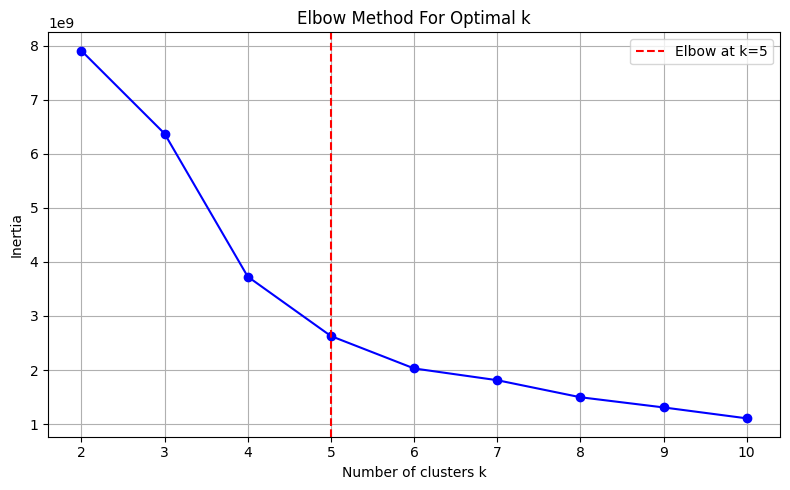


--- Model: Random Forest ---
Saved model to: saved_models/gmm_Random_Forest.joblib

--- Model: XGBoost ---
Saved model to: saved_models/gmm_XGBoost.joblib


In [ ]:
X_train, y_train = train_df.drop(columns="Is Fraudulent"), train_df["Is Fraudulent"]
X_test, y_test = test_df.drop(columns="Is Fraudulent"), test_df["Is Fraudulent"]

print("\n=== Baseline Model: Plain Logistic Regression (No tuning, no feature engineering) ===")

# Create and train baseline model
baseline_model = LogisticRegression(random_state=58, max_iter=500)
baseline_model.fit(X_train, y_train)

# Predict on test set
y_pred_baseline = baseline_model.predict(X_test)
y_proba_baseline = baseline_model.predict_proba(X_test)[:, 1]  # Only use [:, 1] for binary classification

# Evaluate
acc = accuracy_score(y_test, y_pred_baseline)
prec = precision_score(y_test, y_pred_baseline)
rec = recall_score(y_test, y_pred_baseline)
f1 = f1_score(y_test, y_pred_baseline)
f2 = fbeta_score(y_test, y_pred_baseline, beta=2)
auc = roc_auc_score(y_test, y_proba_baseline)
cm = confusion_matrix(y_test, y_pred_baseline)

print(f"Test Accuracy:  {acc:.4f}")
print(f"Test Precision: {prec:.4f}")
print(f"Test Recall:    {rec:.4f}")
print(f"Test F1:        {f1:.4f}")
print(f"Test F2:        {f2:.4f}")
print(f"Test ROC-AUC:   {auc:.4f}")
print("Confusion Matrix:")
print(cm)

# Top 2 Challenger models from KFold CV performance
selected_combinations = {
    "gmm": ["Random Forest", "XGBoost"],
}

os.makedirs("saved_models", exist_ok=True)

print("\n=== Final Inference Results for Selected Tuned Models ===")

for clustering_type, model_list in selected_combinations.items():
    print(f"\n===== Clustering: {clustering_type.upper()} =====")

    # Feature engineer with specified clustering type
    X_train_fe, X_test_fe, _ = further_feature_engineer(X_train.copy(), X_test.copy(), cluster_type=clustering_type)

    for model_name in model_list:
        if model_name not in best_config_per_model:
            continue

        print(f"\n--- Model: {model_name} ---")
        best_params = best_config_per_model[model_name]["best_params"]

        # Set best hyperparameters (remove 'model__' prefix)
        model = models[model_name].set_params(
            **{param.replace('model__', ''): val for param, val in best_params.items()}
        )

        # Create pipeline
        pipeline = ImbPipeline([
            ('oversampler', RandomOverSampler(random_state=58)),
            ('model', model)
        ])

        # Train and save
        pipeline.fit(X_train_fe, y_train)
        filename = f"saved_models/{clustering_type}_{model_name.replace(' ', '_')}.joblib"
        joblib.dump(pipeline, filename)
        print(f"Saved model to: {filename}")

In [ ]:
# # Directory where your models are saved
# saved_model_dir = "drive/MyDrive/Colab Notebooks/DSA4263 Project/saved_models"

# # List all joblib files in the directory
# model_files = [f for f in os.listdir(saved_model_dir) if f.endswith(".joblib")]

# # Download each file
# for model_file in model_files:
#     filepath = os.path.join(saved_model_dir, model_file)
#     files.download(filepath)

## Reading saved models and generate test results

### Test results for challenger model 1 (Random Forest with GMM clustering feature)

[Elbow Method] Optimal k found: 5


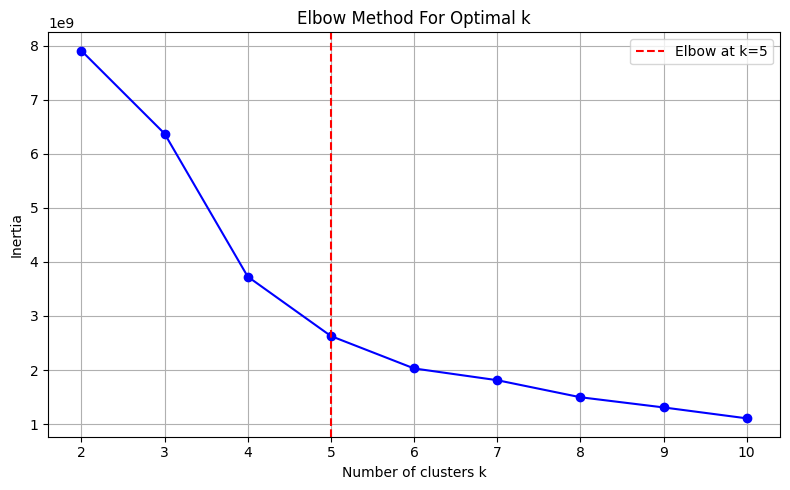

Challenger model 1 Test F2:        0.7410
Challenger model 1 Test ROC-AUC:   0.7955
Challenger model 1 Confusion matrix


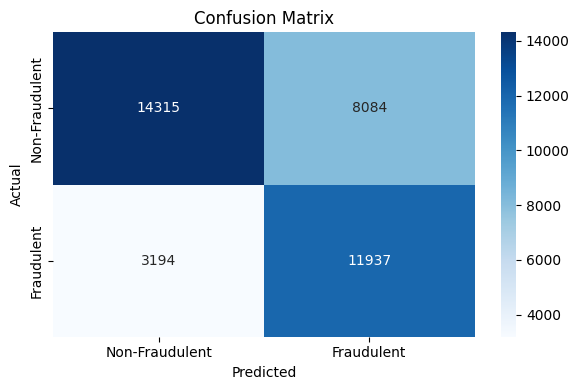

In [ ]:
rf_model = joblib.load("saved_models/gmm_Random_Forest.joblib")
X_train_fe_gmm, X_test_fe_gmm, _ = further_feature_engineer(X_train.copy(), X_test.copy(), cluster_type="gmm")
rf_pred = rf_model.predict(X_test_fe_gmm)
rf_proba = rf_model.predict_proba(X_test_fe_gmm)[:, 1]
f2 = fbeta_score(y_test, rf_pred, beta=2)
auc = roc_auc_score(y_test, rf_proba)
rf_cfm = confusion_matrix(y_test, rf_pred)
print(f"Challenger model 1 Test F2:        {f2:.4f}")
print(f"Challenger model 1 Test ROC-AUC:   {auc:.4f}")
print(f"Challenger model 1 Confusion matrix")
class_labels = ['Non-Fraudulent', 'Fraudulent']
df_cfm = pd.DataFrame(rf_cfm, index=class_labels, columns=class_labels)
plt.figure(figsize=(6, 4))
sns.heatmap(df_cfm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()

### Test results for challenger model 2 (XGBoost with GMM clustering feature)

[Elbow Method] Optimal k found: 5


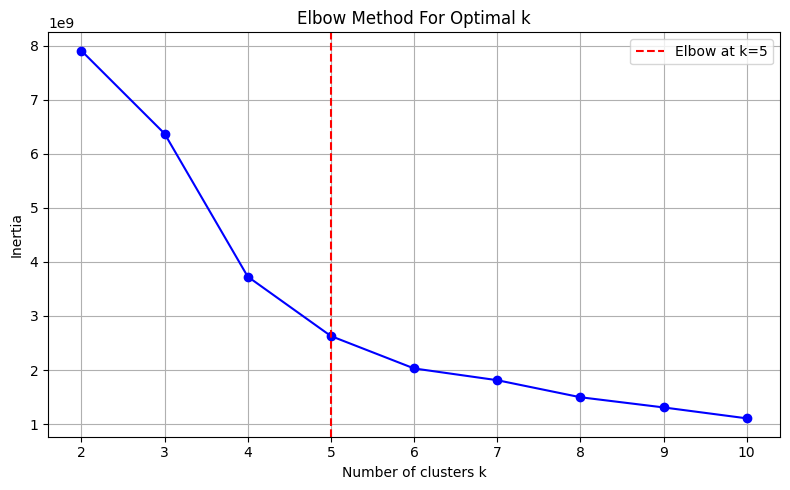

Challenger model 2 Test F2:        0.7216
Challenger model 2 Test ROC-AUC:   0.7843
Challenger model 2 Confusion matrix


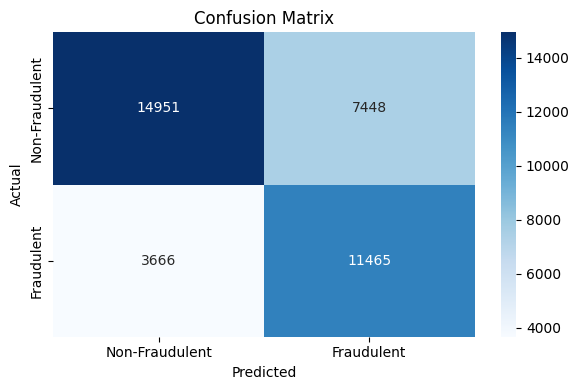

In [ ]:
xgb_model = joblib.load("saved_models/gmm_XGBoost.joblib")
X_train_fe_gmm, X_test_fe_gmm, _ = further_feature_engineer(X_train.copy(), X_test.copy(), cluster_type="gmm")

xgb_pred = xgb_model.predict(X_test_fe_gmm)
xgb_proba = xgb_model.predict_proba(X_test_fe_gmm)[:, 1]
f2 = fbeta_score(y_test, xgb_pred, beta=2)
auc = roc_auc_score(y_test, xgb_proba)
xgb_cfm = confusion_matrix(y_test, xgb_pred)
print(f"Challenger model 2 Test F2:        {f2:.4f}")
print(f"Challenger model 2 Test ROC-AUC:   {auc:.4f}")
print(f"Challenger model 2 Confusion matrix")
class_labels = ['Non-Fraudulent', 'Fraudulent']
df_cfm = pd.DataFrame(xgb_cfm, index=class_labels, columns=class_labels)
plt.figure(figsize=(6, 4))
sns.heatmap(df_cfm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()

## Model Explanations

In [ ]:
def generate_and_visualize_multiple_and_plot_feature_importance(model, X_train, X_test, y_train, indices, model_name, clustering_type):
    explainer = lime.lime_tabular.LimeTabularExplainer(
        training_data=X_train.values,
        mode='classification',
        training_labels=y_train.values,
        feature_names=X_train.columns.tolist(),
        class_names=['Non-Fraudulent', 'Fraudulent'],
        discretize_continuous=True
    )

    for index in indices:
        instance = X_test.iloc[index].values.reshape(1, -1)
        prediction = model.predict(instance)[0]
        prediction_label = 'Fraudulent' if prediction == 1 else 'Non-Fraudulent'
        actual_label = 'Fraudulent' if y_test.iloc[index] == 1 else 'Non-Fraudulent'

        print(f"\nExplaining instance {index} for {model_name} ({clustering_type})...")
        print(f"Actual label   : {actual_label}")
        print(f"Predicted label: {prediction_label}\n")

        explanation = explainer.explain_instance(
            data_row=instance[0],
            predict_fn=model.predict_proba
        )

        explanation.show_in_notebook()

[Elbow Method] Optimal k found: 5


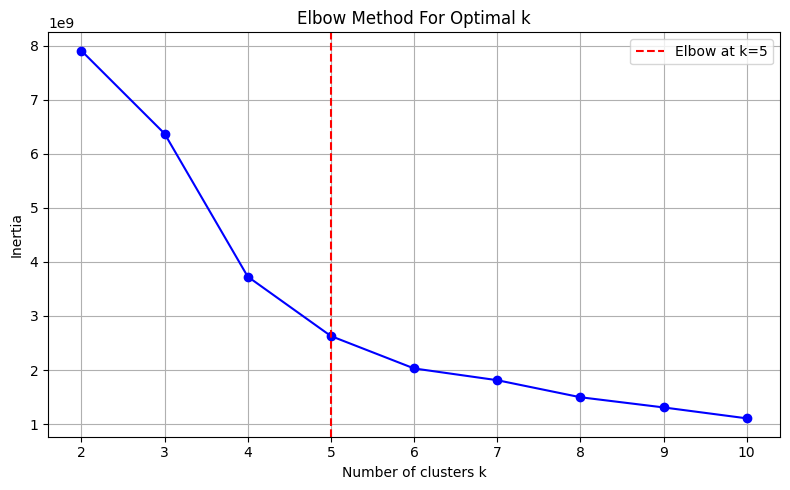

Selected index with low confidence from both models: 2415

📌 Explaining: Both models not confident (proba ~45–55%)

Explaining instance 2415 for Random Forest (gmm)...
Actual label   : Fraudulent
Predicted label: Fraudulent




Explaining instance 2415 for XGBoost (gmm)...
Actual label   : Fraudulent
Predicted label: Fraudulent



In [ ]:
selected_combinations = {
    "gmm": ["Random Forest", "XGBoost"]
}

# Step 0: Feature Engineering
X_train_fe_gmm, X_test_fe_gmm, _ = further_feature_engineer(X_train.copy(), X_test.copy(), cluster_type="gmm")

# Step 1: Load Models
rf_model = joblib.load("saved_models/gmm_Random_Forest.joblib")
xgb_model = joblib.load("saved_models/gmm_XGBoost.joblib")

# Step 2: Get predictions and probabilities
rf_pred = rf_model.predict(X_test_fe_gmm)
rf_proba = rf_model.predict_proba(X_test_fe_gmm)[:, 1]

xgb_pred = xgb_model.predict(X_test_fe_gmm)
xgb_proba = xgb_model.predict_proba(X_test_fe_gmm)[:, 1]

# Convert y_test to numpy if needed
y_true = np.array(y_test)

# Step 3: Define low-confidence range (both models)
low_confidence_indices = [
    i for i in range(len(y_test))
    if 0.45 <= rf_proba[i] <= 0.55 and 0.45 <= xgb_proba[i] <= 0.55
]

# Step 4: Randomly select one index if available
idx_low_conf = random.choice(low_confidence_indices) if low_confidence_indices else None
print(f"Selected index with low confidence from both models: {idx_low_conf}")

# Prepare dataframes for LIME
X_test_gmm_df = pd.DataFrame(X_test_fe_gmm, columns=X_train_fe_gmm.columns)

# Step 5: LIME Explanation for both models on this instance
if idx_low_conf is not None:
    print("\n📌 Explaining: Both models not confident (proba ~45–55%)")

    generate_and_visualize_multiple_and_plot_feature_importance(
        model=rf_model,
        X_train=pd.DataFrame(X_train_fe_gmm, columns=X_train_fe_gmm.columns),
        X_test=X_test_gmm_df,
        y_train=y_train,
        indices=[idx_low_conf],
        model_name="Random Forest",
        clustering_type="gmm"
    )

    generate_and_visualize_multiple_and_plot_feature_importance(
        model=xgb_model,
        X_train=pd.DataFrame(X_train_fe_gmm, columns=X_train_fe_gmm.columns),
        X_test=X_test_gmm_df,
        y_train=y_train,
        indices=[idx_low_conf],
        model_name="XGBoost",
        clustering_type="gmm"
    )

### Overall results


Among all models tested, XGBoost achieved the highest F2-score of 0.7029, indicating its strong ability to balance recall and precision while prioritizing recall — which is crucial in fraud detection to minimize missed fraudulent cases. It also recorded the highest recall (0.7209), aligning well with our goal of reducing false negatives. While Random Forest had slightly higher overall accuracy (0.7553), its F2-score (0.6805) was lower than XGBoost. The Neural Network (NN) model demonstrated comparable performance with an F2-score of 0.6802 and a competitive ROC-AUC of 0.7870, showing potential with further tuning. Overall, XGBoost is the most effective model in our context, where recall-driven performance (via F2) is prioritized.